In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from tqdm.auto import tqdm
from collections import Counter
import networkx as nx
import seaborn as sns

#Necessary for diaplaying all outputs; otherwise only gsd.colums will be displayed. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading data and preprocessing

In [2]:
# Load the data
path = 'data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/'
datasets = {f: pd.read_csv(path + f + '.csv') for f in ['campaign_desc', 'campaign_table',
                                                    'causal_data', 'coupon', 'coupon_redempt',
                                                    'hh_demographic', 'product',
                                                    'transaction_data']}

# Checking for NaN data

In [3]:
def data_missing(dataframes):
    any_missing_data = False

    for (name, dataframe) in dataframes.items():
        any_missing_data = any_missing_data | dataframe.isna().values.any()

    return any_missing_data

print('NaN Data: %r' % data_missing(datasets))
datasets['hh_demographic'].head()

NaN Data: False


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


# Checking for other anomalies in the data

In [4]:
datasets['product']['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

<font color = "green">
    
* Inspecting the `product` dataframe we see that there is a department name that contains only on space in its name. We shall print those lines to see if they have relevant information and if the haven't we shall remove them.

In [5]:
datasets['product'][datasets['product']['DEPARTMENT'].apply(lambda e: len(e)) == 1]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
52189,5126087,1,,National,,,
52190,5126088,1,,National,,,
52191,5126106,1,,National,,,
52192,5126107,1,,National,,,
55048,5977100,1,,National,,,
55054,5978648,1,,National,,,
55055,5978649,1,,National,,,
55056,5978650,1,,National,,,
55057,5978656,1,,National,,,
55058,5978657,1,,National,,,


<font color = 'green'>
    
* The above dataframe contains only 15 entries that do not tell anything, so we remove them.

In [6]:
datasets['product'] = datasets['product'][datasets['product']['DEPARTMENT'].apply(lambda e: len(e)) > 1]
datasets['product']['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

<font color = "green">

We can notice that all the departments have a valid name now.

# Products bought toghether

In [7]:
transactions = datasets['transaction_data']
products = datasets['product']

In [8]:
merged = transactions.merge(products, how = 'inner', on = 'PRODUCT_ID')
merged["Name"] = merged["COMMODITY_DESC"] + " / " + merged["SUB_COMMODITY_DESC"]
essential_data = merged[["BASKET_ID", "Name"]]

In [9]:
counts = Counter()

for _, products in tqdm(essential_data.groupby('BASKET_ID')["Name"]):
    products = np.unique(products)
    for i in range(0, len(products)):
        for j in range(0, i):
            a = products[i]
            b = products[j]
            if a < b:
                sa = a
                sb = b
            else:
                sa = b
                sb = a
            counts[a + ";" + b] += 1

In [10]:
rows = []
for prods,count in tqdm(counts.items()):
    [a,b] = prods.split(";")
    rows.append((a,b,count))

In [11]:
counts_df = pd.DataFrame(rows, columns=["Product 1", "Product 2", "Count"])
counts_df = counts_df[counts_df["Count"] > 10]
counts_df = counts_df.sort_values("Count", ascending=False)

## Introduction

<font color = 'green'>

* We wanted to explore relations between different products - we decided to look for pairs of products that tend to be bought together frequently.

* First we take a look at counts of transactions that both products appear in.

In [12]:
counts_df.head(5)

,Product 1,Product 2,Count
1002,TROPICAL FRUIT / BANANAS,FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY,15662
50,FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY,BAKED BREAD/BUNS/ROLLS / MAINSTREAM WHITE BREAD,14075
123,SOFT DRINKS / SOFT DRINKS 12/18&15PK CAN CAR,FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY,10567
3963,FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY,CHEESE / SHREDDED CHEESE,10349
708,REFRGRATD JUICES/DRNKS / DAIRY CASE 100% PURE ...,FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY,9549


In [13]:
counts_df.iloc[4,0]

'REFRGRATD JUICES/DRNKS / DAIRY CASE 100% PURE JUICE - O'

<font color = 'green'>

* The same table as above but formatted in a pretty way:

* The 5 most often recurring pairs are:

* <small>(We converted the original product names like "TROPICAL FRUIT / BANANAS" to simple, a bit less specific names for simplicity. We also show rounded counts in thousands of transactions.)</small>
    
| Product 1    | Product 2    | Co-occurence count |
|--------------|--------------|--------------------|
| Bananas       | Milk         |  ~16k             |
| Milk         | Bread      |  ~14k             |
| Some soft drink (can) | Milk         |  ~11k             |
| Shredded cheese  | Milk         |  ~10k             |
| Refrigeated juice       | Milk      |  ~15k             |


<font color = 'green'>

As we can see milk is present in almost every pair. This is likely to it being a frequently bought product overall.

In [14]:
popular = merged.groupby("Name").apply(len).sort_values(ascending=False).head(10)
popular

Name
FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY           65764
SOFT DRINKS / SOFT DRINKS 12/18&15PK CAN CAR          39316
SOFT DRINKS / SFT DRNK 2 LITER BTL CARB INCL          37254
YOGURT / YOGURT NOT MULTI-PACKS                       37019
TROPICAL FRUIT / BANANAS                              30436
BAKED BREAD/BUNS/ROLLS / MAINSTREAM WHITE BREAD       27392
CHEESE / SHREDDED CHEESE                              27343
CANDY - CHECKLANE / CANDY BARS (SINGLES)(INCLUDING    25121
COUPON/MISC ITEMS / GASOLINE-REG UNLEADED             23174
BAG SNACKS / POTATO CHIPS                             21787
dtype: int64

<font color = 'green'>

* Indeed, when we look at the top 5 most often bought products, we get almost the same results as for the top pairs:

| Product | Count |
|---------|-------|
| Milk    | ~66k   |
| Some soft drink (can) | ~39k |
| Other soft drink (2L bottle) | ~37k |
| Yogurt | ~37k |
| Bananas | ~30k |

* Products that are more often bought overall are more likely to form the pairs of being bought together (because if both products have high probability of being bought in a transaction, the join probability is also higher than for products that are bough rarely overall).

* To look further, we will look at relative counts - for each pair we will divide the co-occurrence count by the amount of transactions each of the products is in and take the bigger value. 

In [15]:
sales = merged.groupby(["Name"]).apply(lambda df: df["BASKET_ID"].nunique())

In [16]:
relativized = counts_df.merge(sales.rename("Sales 1"), left_on="Product 1", right_on="Name").merge(sales.rename("Sales 2"), left_on="Product 2", right_on="Name")

In [17]:
relativized["Relative Count 1"] = relativized["Count"] / relativized["Sales 1"]
relativized["Relative Count 2"] = relativized["Count"] / relativized["Sales 2"]
relativized["Relative Count"] = relativized[["Relative Count 1", "Relative Count 2"]].max(axis=1)
relativized_filt = relativized[relativized["Count"] > 100]
relativized_filt = relativized_filt.sort_values("Relative Count", ascending=False)

In [18]:
relativized_filt.head(10)

,Product 1,Product 2,Count,Sales 1,Sales 2,Relative Count 1,Relative Count 2,Relative Count
252552,SALAD BAR / SALAD BAR FRESH FRUIT,SALAD BAR / CONDIMENTS/SUPPLIES,408,7893,447,0.051691,0.912752,0.912752
11091,PROCESSED / FRUIT GLAZES,BERRIES / STRAWBERRIES,189,259,7331,0.729730,0.025781,0.729730
224503,FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY,CONVENIENT BRKFST/WHLSM SNACKS / INSTANT BREAK...,193,61383,265,0.003144,0.728302,0.728302
239137,FRZN MEAT/MEAT DINNERS / FRZN SS PREMIUM ENTRE...,FROZEN PIZZA / FRZN SS PREMIUM ENTREES/DNRS/N,183,5361,254,0.034135,0.720472,0.720472
235971,MILK BY-PRODUCTS / SOUR CREAMS,BAG SNACKS / SALAD DRESSING MIXES,242,8789,341,0.027534,0.709677,0.709677
114145,BAKING MIXES / LAYER CAKE MIX,BAKING MIXES / FROSTING,2122,3627,3089,0.585057,0.686954,0.686954
16962,HISPANIC / DIPS (NON-REFRIGERATED),BAG SNACKS / TORTILLA/NACHO CHIPS,108,159,12897,0.679245,0.008374,0.679245
3235,MILK BY-PRODUCTS / RICOTTA CHEESE,CHEESE / SHREDDED CHEESE,490,736,21048,0.665761,0.023280,0.665761
122224,HAIR CARE PRODUCTS / SHAMPOO,HAIR CARE PRODUCTS / HAIR CONDITIONERS AND RINSES,1716,4246,2583,0.404145,0.664344,0.664344
3183,CONDIMENTS/SAUCES / PIZZA SAUCE,CHEESE / SHREDDED CHEESE,618,941,21048,0.656748,0.029361,0.656748


## Relative count

<font color = 'green'>

* Below we can see the top 5 pairs after relativizing the co-occurences. We have also removed pairs which were bought less than 100 times (because when one product was bought only once ever, it would result in 100% but that is not a useful conclusion but rather an outlier).

* The interpretation of percentage is following: of all transactions where Primary product was bought, it shows the fraction of transactions where Secondary product was bought as well.

| Primary product | Secondary product | % of times secondary product was bought along the primary one | 
|-|-|-|
| Salad condiments (Salad bar) | Fresh fruit (Salad bar) | 91% |
| Fruit glazes | Strawberries | 73% |
| Instant breakfast | Milk | 73% | 
| Frozen pizza (some particular variant) | Frozen meat entree | 72% |
| Salad dressing mix | Sour cream | 71% |

* For example, we can see that 91% of the times Salad condiments were bought at the salad bar, fresh fruit was also bought. This correlation seems quite likely as these are just 2 products from the salad bar, so they tend to be bought together quite often.

* Then we can see that 73% of the time someone buys a fruit glaze, they also buy strawberries - of course they need something to put the glaze on, and strawberries look like a very common choice. Maybe it's a good idea for the retailers to do some promotions on buying these two together?

* Then we can guess that the Instant breakfast is actually a kind of cereal package, as 73% of times it is bought it is bought with milk as well.

* We can also see that people often buy sour cream along with the salad dressing. Also, many fans of frozen pizza also like an entree.

## Groups of products

Text(0.5, 0, 'Co-occurrence count')

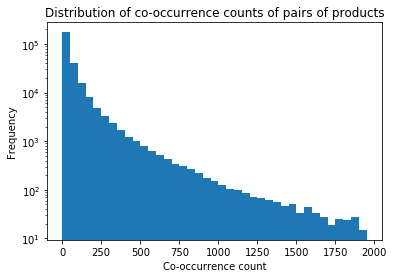

In [19]:
counts_df["Count"].plot.hist(bins=range(0, 2000, 50), log=True)
plt.title('Distribution of co-occurrence counts of pairs of products')
plt.xlabel('Co-occurrence count')

In [20]:
(counts_df["Count"] > 1000).sum()

1346

<font color = 'green'>

* The next goal was to look at groups of products bigger than mere pairs.

* As there are exponentially many subsets of all products we couldn't have counted them by brute-force, so we came with an approximation. We look at pairs of products that are bought together often (after looking at the distribution of co-occurence counts, we decided for a threshold of sharing at least 1000 transactions) and form a graph. Than we look for cliques in this graph - a clique is a set of products of which each pair was often bought together.

In [21]:
bigger_counts = counts_df[counts_df["Count"] > 3000]

In [22]:
graph = nx.from_pandas_edgelist(bigger_counts, 'Product 1', 'Product 2', edge_attr="Count", create_using= nx.Graph())

In [23]:
cliques = list(nx.clique.find_cliques(graph))

In [24]:
maxlen = max(map(len, cliques))

In [25]:
chosen_clique = None
chosen_w = None

for clique in cliques:
    if len(clique) >= maxlen:
        weights = []
        for a in clique:
            for b in clique:
                if a != b:
                    weights.append(graph.get_edge_data(a,b)["Count"])
        print("Each pair has been bought together " + str(min(weights)) + " times:")
        if chosen_clique is None or min(weights) > chosen_w:
            chosen_w = min(weights)
            chosen_clique = clique

Each pair has been bought together 3134 times:
Each pair has been bought together 3460 times:


In [26]:
chosen_clique

['FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY',
 'TROPICAL FRUIT / BANANAS',
 'BAKED BREAD/BUNS/ROLLS / MAINSTREAM WHITE BREAD',
 'CHEESE / SHREDDED CHEESE',
 'BAG SNACKS / POTATO CHIPS',
 'SOFT DRINKS / SOFT DRINKS 12/18&15PK CAN CAR']

In [27]:
def contains_clique(df):
    names = list(df["Name"])
    for p in chosen_clique:
        if p not in names:
            return False
    return True

In [28]:
tqdm.pandas()

C:\Users\ALEX\Anaconda3\lib\site-packages\tqdm\std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [29]:
containing = merged.groupby("BASKET_ID").progress_apply(contains_clique)

In [30]:
containing.sum()

161

<font color = 'green'>

* We have found that each pair of the following products has been bought together at least 3460 times:
     - Milk
     - Bananas
     - White bread
     - Shredded cheese
     - Potato chips
     - A soft drink in a can

* There have been indeed 161 transactions that contained all of these items at once.

In [31]:
bigger_counts = relativized_filt[relativized_filt["Relative Count"] > 0.25]

In [32]:
graph = nx.from_pandas_edgelist(bigger_counts, 'Product 1', 'Product 2', edge_attr="Relative Count", create_using= nx.Graph())

In [33]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 945
Number of edges: 2264
Average degree:   4.7915


In [34]:
cliques = list(nx.clique.find_cliques(graph))

In [35]:
maxlen = max(map(len, cliques))

In [36]:
chosen_clique = None
chosen_w = None

for clique in cliques:
    if len(clique) >= maxlen:
        weights = []
        for a in clique:
            for b in clique:
                if a != b:
                    weights.append(graph.get_edge_data(a,b)["Relative Count"])
        print("Each pair has been bought together " + str(min(weights)) + " times:")
        print(clique)
        if chosen_clique is None or min(weights) > chosen_w:
            chosen_w = min(weights)
            chosen_clique = clique

Each pair has been bought together 0.2958827634333566 times:
['FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY', 'BAG SNACKS / TORTILLA/NACHO CHIPS', 'HISPANIC / MEXICAN SEASONING MIXES', 'CHEESE / SHREDDED CHEESE', 'HISPANIC / MEXICAN SAUCESSALSAPICANTEE', 'HISPANIC / MEXICAN BEANS REFRIED']
Each pair has been bought together 0.2870662460567823 times:
['FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY', 'BAKED BREAD/BUNS/ROLLS / MAINSTREAM WHITE BREAD', 'CHEESES / CHEESE: NATURAL BULK', 'DELI MEATS / MEAT:HAM BULK', 'DELI MEATS / MEAT: TURKEY BULK', 'DELI MEATS / MEAT: BEEF BULK']
Each pair has been bought together 0.2861919090605149 times:
['FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY', 'BAKED BREAD/BUNS/ROLLS / MAINSTREAM WHITE BREAD', 'CHEESES / CHEESE: NATURAL BULK', 'DELI MEATS / MEAT:HAM BULK', 'DELI MEATS / MEAT: TURKEY BULK', 'DELI MEATS / MEAT: SAUS DRY BULK']
Each pair has been bought together 0.2570194384449244 times:
['FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY', 'BAKED BREAD/BUNS

In [37]:
chosen_clique

['FLUID MILK PRODUCTS / FLUID MILK WHITE ONLY',
 'BAKED BREAD/BUNS/ROLLS / MAINSTREAM WHITE BREAD',
 'VEGETABLES - SHELF STABLE / CORN',
 'VEGETABLES - SHELF STABLE / BEANS GREEN: FS/WHL/CUT',
 'VEGETABLES - SHELF STABLE / CARROTS',
 'VEGETABLES - SHELF STABLE / PEAS GREEN']

In [38]:
containing = merged.groupby("BASKET_ID").progress_apply(contains_clique)

In [39]:
containing.sum()

41

<font color = 'green'>

* We have found out there were 32 transactions where all of:
    - Milk
    - Bananas
    - Corn 
    - Green beans
    - Green peas
    - Carrots
 
have been bought together. Looks like Milk and Bananas showed there mostly due to their very high popularity, but the rest look like common ingredients for a homemade salad.

* Moreover, we found 47 transactions where all of:
    - Milk
    - Tortilla / nacho chips
    - Shredded cheese
    - Mexican salsa
    - Mexican beans (refried)
    - Mexican seasoning mix
have been bought. 

* Of course 32 or 47 is very little transactions, but these are containing the full set of all these ingredients. The amount of transactions each subset will be significantly bigger.

# Seasonality

## Spending on days of week

<font color = 'green'>

* We have analyzed how many transactions are made on each day.

* Unfortunately, our data didn't have labels specifying which number corresponds to which day of the week, but we tried to make some hypotheses.

In [40]:
transactions = datasets['transaction_data']
transactions["DAY_OF_WEEK"] = (transactions["DAY"] - 6) % 7 + 1

In [41]:
dow = transactions.groupby(["DAY_OF_WEEK"])["BASKET_ID"].nunique()

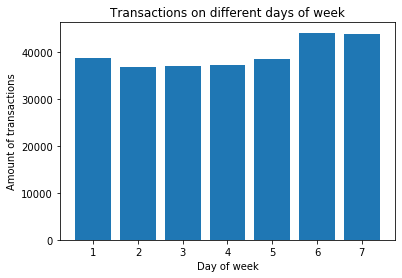

In [42]:
plt.bar(dow.index, dow)
plt.title("Transactions on different days of week")
plt.xlabel("Day of week")
plt.ylabel("Amount of transactions")
plt.show()

<font color = 'green'>

* As we can see, there are most transactions on days 6 and 7 and least on 2, 3 and 4. 

* We hypothesize that 6 and 7 are Saturday and Sunday because it is likely that more transactions would be made during the weekend as most people have time on these days to go shopping. One thing we have considered is that in many countries shops are actually closed on Sundays, so that would result in a big drop of sales on that day, but there is no day that would be a clear outlier of having almost none transactions, so we guess that these shops operate on every day of the week.

* The small increase on days 1 and 5 seems in line with this hypothesis, as people are likely going shopping slightly more often on Mondays for example to refill after having guests on the weekend and on Fridays for numerous reasons (to prepare for a weekend trip or a party, or just having finished work).

In [43]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [44]:
products = datasets['product']
demographic = datasets['hh_demographic']

In [45]:
merged = transactions.merge(products)

In [46]:
transactions_demographic = merged.merge(demographic)

<font color = 'green'>

* Also after looking at how many transactions people from each group are making, we can see that while most people's habits don't differ that much with age, there is is a tendency for older people to do shopping on Sundays much less often then younger ones.

* The youth actually seems to prefer Sundays as their favorite shopping day, while the seniors are actually prefering Fridays.

In [47]:
data = transactions_demographic[(transactions_demographic.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")]

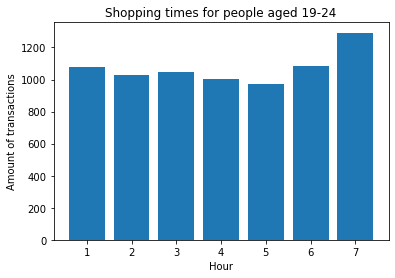

In [48]:
stat = data[data["AGE_DESC"] == "19-24"].groupby("DAY_OF_WEEK")["BASKET_ID"].nunique()
plt.title("Shopping times for people aged 19-24")
plt.xlabel("Hour")
plt.ylabel("Amount of transactions")
plt.bar(stat.index, stat)
plt.show()

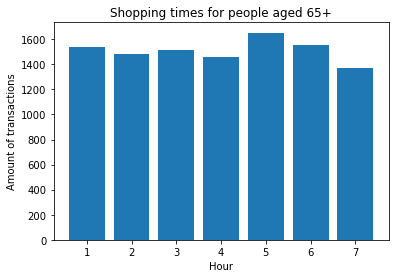

In [49]:
stat = data[data["AGE_DESC"] == "65+"].groupby("DAY_OF_WEEK")["BASKET_ID"].nunique()
plt.title("Shopping times for people aged 65+")
plt.xlabel("Hour")
plt.ylabel("Amount of transactions")
plt.bar(stat.index, stat)
plt.show()

## Sales at different times of day

<font color = 'green'>

We now look if there are any rush hours in the shops.

In [50]:
transactions["HOUR"] = np.floor(transactions.TRANS_TIME / 100).apply(int)

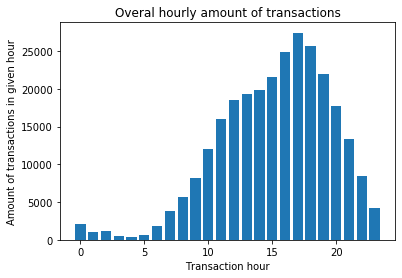

In [51]:
overall = transactions.groupby("HOUR")["BASKET_ID"].nunique()
plt.bar(overall.index, overall)
plt.title("Overal hourly amount of transactions")
plt.xlabel("Transaction hour")
plt.ylabel("Amount of transactions in given hour")
plt.show()

<font color = 'green'>

We now compare the amount of transactions on the weekends and the weekdays.

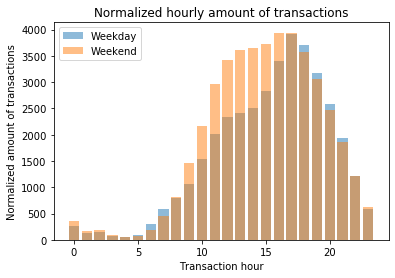

In [52]:
weekday = transactions[transactions["DAY_OF_WEEK"] < 6].groupby("HOUR")["BASKET_ID"].nunique()
plt.bar(weekday.index, weekday / 5, label="Weekday", alpha=0.5)
weekend = transactions[transactions["DAY_OF_WEEK"] >= 6].groupby("HOUR")["BASKET_ID"].nunique()
plt.bar(weekend.index, weekend / 2, label="Weekend", alpha=0.5)
plt.title("Normalized hourly amount of transactions")
plt.xlabel("Transaction hour")
plt.ylabel("Normalized amount of transactions")
plt.legend()
plt.show()

<font color = 'green'>

* As the weekend lasts only 2 days and there are 5 weekdays, to get a fair comparison, we have divided the transaction amounts on weekends by 2 and by 5 on weekdays. So the bar height represents the average amount of transactions on one day of the respective period.

* We can see that on weekdays there are much less sales between 9 and 16. Of course this makes sense as during the week, most people are working during that time. There are more sales in the early morning and late evening likely caused by people doing the shopping before or after work.

In [53]:
transactions_demographic["HOUR"] = np.floor(transactions_demographic.TRANS_TIME / 100).apply(int)

In [54]:
def times_over_category(data, category_column, show_separate=True, sort=True, minimal_threshold=None):
    
    sums = data.groupby([category_column, "HOUR"])["BASKET_ID"].nunique()
    overall = data.groupby(category_column)["BASKET_ID"].nunique()
    if minimal_threshold is not None:
        sums = sums[sums.index.isin(overall[overall > minimal_threshold].index, level=0)]

    values = sums.index.unique(level=0)
    if sort:
        values = sorted(values)
        
    if show_separate:
        for cat in values:
            stat = sums[cat]
            plt.title("Shopping times for category " + cat)
            plt.xlabel("Hour")
            plt.ylabel("Amount of transactions")
            plt.bar(stat.index, stat)
            plt.show()
    
    # for the second step we normalize the sums
    
    sums = sums / overall

    
    plt.figure(figsize=(10,8))
    for cat in values:
        stat = sums[cat]
        plt.plot(stat.index, stat, label=cat)
    plt.xlabel("Hour")
    plt.ylabel("Relative amount of transactions")
    plt.title("Relativized comparison of transaction times of different ages")
    plt.legend()
    plt.show()

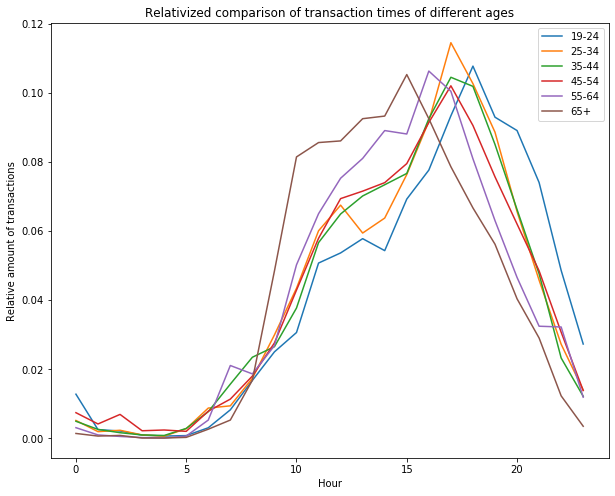

In [55]:
times_over_category(transactions_demographic[(transactions_demographic.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")], "AGE_DESC", show_separate=False)

<font color = 'green'>

* Here we can see that older people tend to do the shopping in the late morning and early afternoon - starting at 9, and with a peak activity at 15.

* Adults tend to do most of their shopping later - with most of them shopping around 17-18.

* The youngest age group (19-24) tend to do the shopping in the evening - peaking around 18 and being relatively more active in the night.


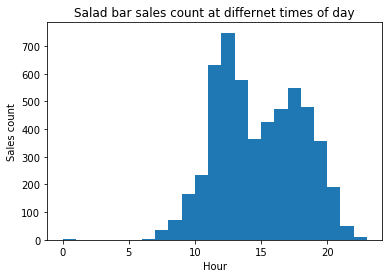

In [56]:
transactions_demographic[transactions_demographic.DEPARTMENT == "SALAD BAR"]["HOUR"].plot.hist(bins=range(24))
plt.title("Salad bar sales count at differnet times of day")
plt.ylabel("Sales count")
plt.xlabel("Hour")
plt.show()

<font color = 'green'>

As we can see the salad bar has a big spike at around 1pm which suggests lots of clients buy salads for lunch, the later increase around 5pm is likely caused by clients buying salads after work or during their normal shopping (overall sales also peak at ~5pm) for example for the next day.

## Long term correlations

<font color = 'green'>

* We wanted to see if sales of some products correlate with others. We have plotted sales in different categories and normalized them to see the correlations more easily.

* Some categories have very little sales over all, so even if they would correlate with other it would be hard to see that on a plot without normalizing.

In [57]:
def compare_specific_categories(data, category_column, labels, statistic_computation, sort=True, title=None):
    data = data[data[category_column].isin(labels)]
    
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))

    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):

        plt.plot(stat.index, stat, label=cat)
        #print(stat)
    plt.xlabel("Month")
    plt.ylabel("Relative sales in given month")
    if title is None:
        title = "Comparison over " + category_column
    plt.title(title)
    plt.legend()
    plt.show()

def stat_relative_overall_monthly_quantity(data):
    overall = data["QUANTITY"].sum()
    return (data.groupby("MONTH")["QUANTITY"].sum() / overall)

def stat_relative_minmax_overall_monthly_quantity(data):
    monthly = data.groupby("MONTH")["QUANTITY"].sum()
    mini = monthly.min()
    maxi = monthly.max()
    return (monthly - mini) / (maxi - mini)

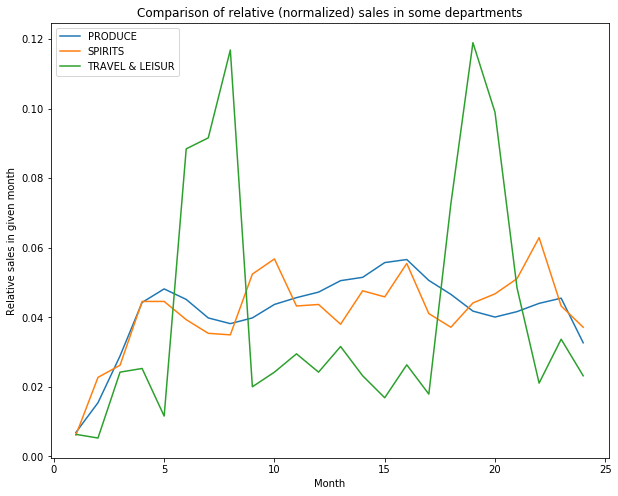

In [58]:
compare_specific_categories(merged, "DEPARTMENT", ["TRAVEL & LEISUR", "SPIRITS", "PRODUCE"], stat_relative_overall_monthly_quantity, title="Comparison of relative (normalized) sales in some departments")

<font color = 'green'>

* We can see that TRAVEL has cyclical spikes in months 6-8 (which coincides with summer) likely due to people going on vacation.

* At the same time there is a light drop in SPIRITS and PRODUCE sales (PRODUCE is mostly daily food products). This can likely be explained by the fact that people going on vacation often don't do the regular shopping (for example because they are more likely to dine in a restaurant rather than cook) and go abroad (so their shopping is not counted in the dataset we have).

# Spending trends

<font color = 'green'>

We analyze how much people spend on shopping and how that value changes over time.

In [59]:
def plot_trend(x, y, xlabel, ylabel, title, std=None):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    if std is not None:
        plt.fill_between(monthly.index, monthly - std, monthly + std, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [60]:
transactions = datasets['transaction_data']

## Weekly spending

<font color = 'green'>

First we take a look at the mean household spending each week and see how it varies over time.

In [61]:
# we compute mean 
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum().groupby("WEEK_NO").mean().sort_index()

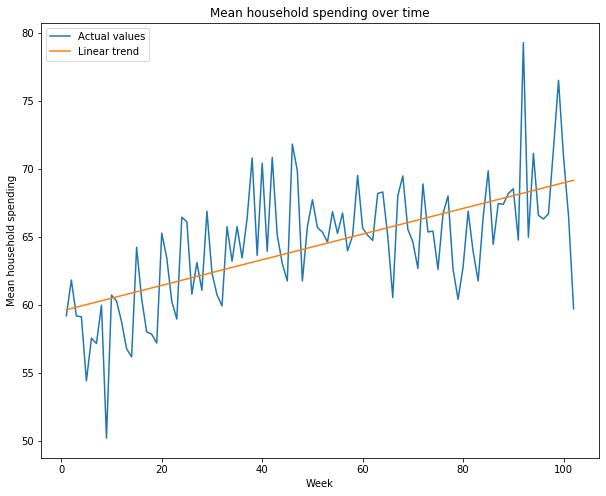

In [62]:
plot_trend(weekly.index, weekly, "Week", "Mean household spending", "Mean household spending over time")

<font color = 'green'>

There is a high deviation between subsequent weeks, but we can see that the sales are overall increasing over time. The linear regression shows a rising tendency.

## Monthly spending

<font color = 'green'>

To deal with the very high variance between weeks, we will now look at the spending within a longer time interval - a month.

In [63]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [64]:
# Now we compute mean household spending in each month
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().groupby("MONTH")["SALES_VALUE"].mean()

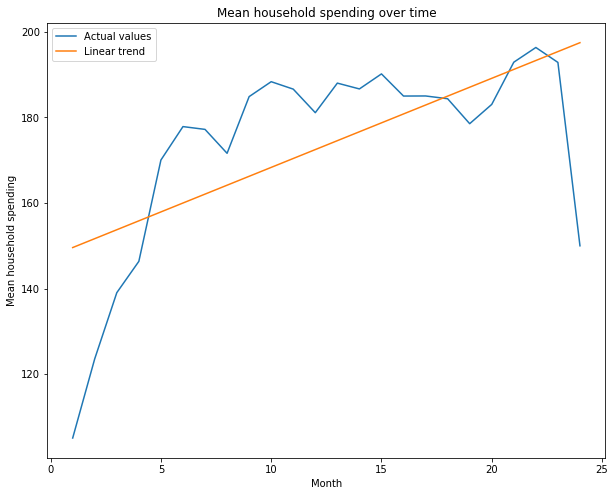

In [65]:
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

<font color = 'green'>

The plot is much smoother and we can indeed see an increasing trend, especially at the very beginning (in the first half of the fist year). After half a year the trend seems to still be rising, however it slows down a lot in comparison to the first months.

## Some explanation

It is important to note how we should understand the data we have: we have sales data for a specific set of stores. The fact that we see an increase in spending over time what we really see is increase in store's sales. It is possible that it is due to the people starting o spend more money, but it is equally possible that they are spending the same amount, but choosing the stores we have access to more frequently instead of other stores that are not in this database. In fact the big rise in the first half a year could be explained by the store starting a marketing campaign - the small sales in the beginning could mean new customers starting to sometimes go to this stores and the rapid increase could be the result of them starting to choose it more and more often over other stores due to marketing. The slowdown afterwards may be due to saturation - most interested customers already have started to frequent these stores often and they don't change their habits that much anymore.

In [66]:
monthly_sales = transactions.groupby(["MONTH"])["SALES_VALUE"].sum()

## Individual trends

<font color = 'green'>
    
However people are not a namelss mass but a group of individuals. The mean household spending seems to be rising, but does that mean that all the people are spending more and more? Let's find out.

In [68]:
def find_absolute_coef(data):
    data = data.rename("count").sort_index().reset_index()
    model = LinearRegression()
    X = data["WEEK_NO"].to_numpy() / 102
    y = data["count"].to_numpy()
    # we fit a Linear Regression to find a line best fitting the change in spending over time
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    return model.coef_[0][0]

In [69]:
def find_percentage_change(data):
    data = data.rename("count").sort_index().reset_index()
    model = LinearRegression()
    X = data["WEEK_NO"].to_numpy() / 102
    y = data["count"].to_numpy()
    # we fit a Linear Regression to find a line best fitting the change in spending over time
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    
    # we now compute the percentage change    
    return (100 * (model.coef_[0][0]) / model.intercept_[0])

In [70]:
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum()

<font color = 'green'>

* We now try to fit a Linear Regression model to the weekly spending of each household. The fitted line represents a 'trend' in the spending of the household - if the line is going upwards it means the household is spending more and if it is downwars the household is likely to started saving. A horizontal line means the spending stays more or less the same.

* We will compute a percentage spending change - we fit the line to weekly spending (to avoid the high variance, the line is an approximation of a long term tendency) and assume the line's height in the first week is the starting value and its height in the last week is the final value and compute the percentage difference between the two.

In [71]:
absolute_trends = weekly.groupby("household_key").apply(find_absolute_coef)
percentage_trends = weekly.groupby("household_key").apply(find_percentage_change)

<font color = 'green'>

We have dropped some outliers from the data which were mostly households that did very few transactions. Given too few transactions the trend approximation was too imprecise to give good results.

In [72]:
absolute_trends = absolute_trends[absolute_trends.abs() < 500]

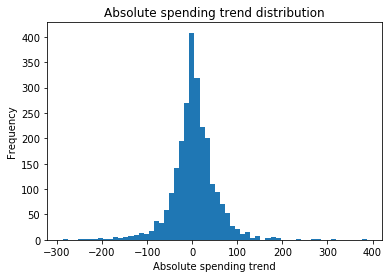

In [73]:
absolute_trends.plot.hist(bins=60, log=False)
plt.title("Absolute spending trend distribution")
plt.xlabel("Absolute spending trend")
plt.show()

<font color = 'green'>

* The absolute spending trend is just the coefficient of the linear trend - it is very dependent on the initial value. If someone was spending 200k in the beginning and in the end they are spending 210k, the coefficient would be the same as in the case someone was spending 10k and started spending 20k, but in fact these changes are drastically different (5% vs 100% increase).

* That is why we will now analyse the percentage change described earlier - it is a better metric in terms of habits. Because a 2x is very different from a 5% change.

In [74]:
100 * (percentage_trends.abs() > 1000).sum() / len(percentage_trends)

3.0

<font color = 'green'>

We checked that only 3% of samples are extreme outliers (with percentage bigger than 1000%), so we skipped them in the histograms to make them more readable. They are likely caused by households doing not too many transactions and the trend approximation being imprecise with too few samples.

In [75]:
percentage_trends = percentage_trends[percentage_trends.abs() < 1000]

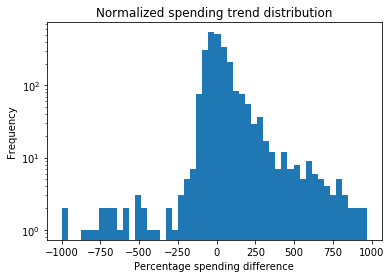

In [76]:
percentage_trends.plot.hist(bins=50,log=True)
plt.title("Normalized spending trend distribution")
plt.xlabel("Percentage spending difference")
plt.show()

<font color = 'green'>

* A positive value means the spending has been increased - for example 100% means the spending is now twice as at the beginning, 0% means no change and -50% means the spending has decreased by 50% since the beginning.

* Values smaller then -100% may look suspicious - what they represent is samples where there wasn't too much data so the approximated spending trend is indicating that at the end of the period they would be spending negative amounts which is of course illogical.

* We can however treat these values just as big negative values, because these customers were spending much less over time.

In [77]:
print("The median percentage difference is " + str(np.round(np.median(percentage_trends), 2)) + "%, but the average is " + str(np.round(np.mean(percentage_trends), 2)) + "%")

The median percentage difference is 2.79%, but the average is 32.45%


<font color = 'green'>

We can see that the mean is much bigger than the median - there are some people that have greatly increased their spending, but most people actually increased only slightly.

In [78]:
nochange = np.round(100.0 * (percentage_trends.abs() < 10).sum() / len(percentage_trends), 2)
print(str(nochange) + "% of households have not changed their spending by more than 10%")

12.41% of households have not changed their spending by more than 10%


In [79]:
incr = np.round(100.0 * (percentage_trends > 10).sum() / len(percentage_trends), 2)
incr2 = np.round(100.0 * (percentage_trends > 50).sum() / len(percentage_trends), 2)
print(str(incr) + "% of households have increased their spending by 10% or more")

45.94% of households have increased their spending by 10% or more


In [80]:
decr = np.round(100.0 * (percentage_trends < -10).sum() / len(percentage_trends), 2)
print(str(decr) + "% of households have decreased their spending by 10% or more")

41.65% of households have decreased their spending by 10% or more


<font color = 'green'>

We can see that most people have indeed increased their spending, but almost as many have actually decreased it.

# Discounts

#  How types of promotions and promotions in general impact sales?

<font color = "green">
* The aim of this section is show the efficacy of a particualr discount medium on the sales of a particular category. In this section we consider sales and promotion information on the top five products from each of the top three
brands within four selected categories (mouthwash, pretzels, frozen pizza, and boxed cereal), gathered from a sample of stores over 156 weeks.

In [2]:
#Loading the dataframes
products=pd.read_csv("data/products.csv")
transactions=pd.read_csv("data/transactions.csv")
stores=pd.read_csv("data/stores.csv")

In [3]:
# showing the heads of the data frames
products.head()
transactions.head()
stores.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111035398,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
0,2009-01-14 00:00:00,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1
1,2009-01-14 00:00:00,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,0
2,2009-01-14 00:00:00,367,1111009507,14,14,14,19.32,1.38,1.38,0,0,0
3,2009-01-14 00:00:00,367,1111035398,4,3,3,14.00,3.50,4.49,0,0,1
4,2009-01-14 00:00:00,367,1111038078,3,3,3,7.50,2.50,2.50,0,0,0


,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24766.807692
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.519231
2,4259,WARSAW AVENUE,CINCINNATI,OH,17140,VALUE,NaN,48813,31177.333333
3,6379,KINGWOOD,KINGWOOD,TX,26420,MAINSTREAM,NaN,50237,20620.423077
4,6431,AT WARD ROAD,BAYTOWN,TX,26420,VALUE,350.0,43698,24321.942308


In [4]:
products.CATEGORY.unique()

array(['BAG SNACKS', 'ORAL HYGIENE PRODUCTS', 'COLD CEREAL',
       'FROZEN PIZZA'], dtype=object)

In [5]:
transactions.WEEK_END_DATE.unique().size

156

In [6]:
transactions = transactions.dropna(axis=0)
transactions['Discount'] = transactions.FEATURE | transactions.DISPLAY | transactions.TPR_ONLY
transactions['Discount_Percentage']= (transactions.BASE_PRICE - transactions.PRICE)/transactions.BASE_PRICE
transactions.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,Discount,Discount_Percentage
0,2009-01-14 00:00:00,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1,1,0.11465
1,2009-01-14 00:00:00,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,0,0,0.00000
2,2009-01-14 00:00:00,367,1111009507,14,14,14,19.32,1.38,1.38,0,0,0,0,0.00000
3,2009-01-14 00:00:00,367,1111035398,4,3,3,14.00,3.50,4.49,0,0,1,1,0.22049
4,2009-01-14 00:00:00,367,1111038078,3,3,3,7.50,2.50,2.50,0,0,0,0,0.00000


####  Total sale, sale in dicount period, sale in normal period per category

In [7]:
Total_sale = transactions.merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
             .groupby('CATEGORY').UNITS.sum().reset_index()

Total_sale_normal = transactions[transactions.Discount==0]\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').UNITS.sum().reset_index()\
                     .rename(columns={'UNITS':'UNITS_NORMAL'})

Total_sale_discount = transactions[transactions.Discount==1]\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').UNITS.sum().reset_index()\
                     .rename(columns={'UNITS':'UNITS_DISC'})

In [8]:
sales_combined = Total_sale\
                 .merge(Total_sale_normal, on='CATEGORY', how='left')\
                 .merge(Total_sale_discount, on='CATEGORY', how='left')
sales_combined

,CATEGORY,UNITS,UNITS_NORMAL,UNITS_DISC
0,BAG SNACKS,2601247,1490290,1110957
1,COLD CEREAL,5826783,3301659,2525124
2,FROZEN PIZZA,1341731,609736,731995
3,ORAL HYGIENE PRODUCTS,521140,282085,239055


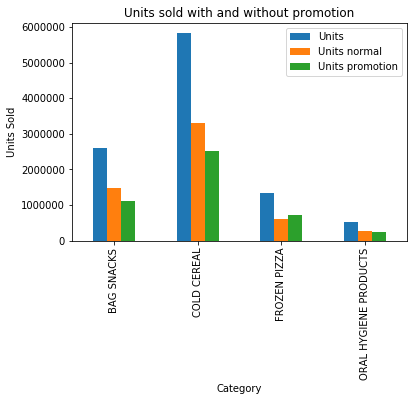

In [9]:
_ = sales_combined.plot(kind='bar', x='CATEGORY', y=['UNITS', 'UNITS_NORMAL', 'UNITS_DISC'],\
                        label=['Units', 'Units normal', 'Units promotion'], title='Units sold with and without promotion')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold")
plt.show()

#### Sales by Feature, Display, or TPR_Only

<font color = "green">
    
* Feature: product was is in-store circular. 
    
    
* Display: product was a part of an in-store circular.
    
* TPR: temporary price reduction only (i.e., shelf tag only. Product's price was reduced but was not on display or in an advertisement)    

In [10]:
Total_sale_feature = transactions[transactions.FEATURE==1]\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').UNITS.sum().reset_index()\
                     .rename(columns={'UNITS':'UNITS_FEATURE'})
Total_sale_display = transactions[transactions.DISPLAY==1]\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').UNITS.sum().reset_index()\
                     .rename(columns={'UNITS':'UNITS_DISPLAY'})
Total_sale_Only = transactions[transactions.TPR_ONLY==1]\
                    .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').UNITS.sum().reset_index()\
                     .rename(columns={'UNITS':'UNITS_ONLY'})

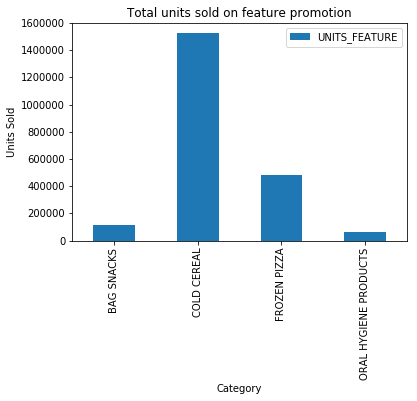

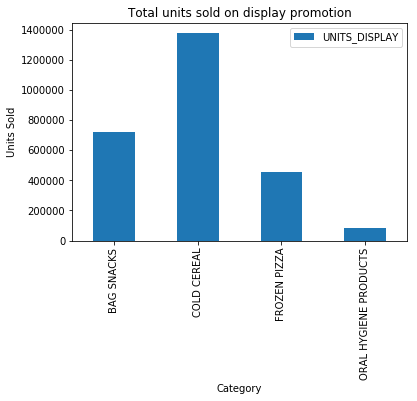

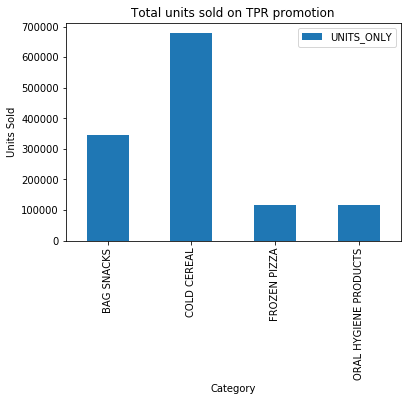

In [11]:
_ = Total_sale_feature.plot(kind='bar', x='CATEGORY', y='UNITS_FEATURE', title='Total units sold on feature promotion')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold")
plt.show()
_ = Total_sale_display.plot(kind='bar', x='CATEGORY', y='UNITS_DISPLAY', title='Total units sold on display promotion')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold")
plt.show()
_ = Total_sale_Only.plot(kind='bar', x='CATEGORY', y='UNITS_ONLY', title='Total units sold on TPR promotion')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold")
plt.show()

<font color = "green">
    
### Normalised sales

Absolute sales numbers do not take into account the frequency of promotions and the number of stores a type of promotion was featured in. Therefore, it is important to normalise the sales to do way with the aforementioned limitations.

In [12]:
Ndays_normal = transactions[transactions.Discount==0]\
                     .groupby(['WEEK_END_DATE','UPC'])\
                     .STORE_NUM.size().reset_index()\
                     .groupby('UPC').STORE_NUM.sum().reset_index()\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').STORE_NUM.sum().reset_index()\
                     .rename(columns={'STORE_NUM':'NORM_UNITS_NORMAL'})

Ndays_discount = transactions[transactions.Discount==1]\
                     .groupby(['WEEK_END_DATE','UPC'])\
                     .STORE_NUM.size().reset_index()\
                     .groupby('UPC').STORE_NUM.sum().reset_index()\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').STORE_NUM.sum().reset_index()\
                     .rename(columns={'STORE_NUM':'NORM_UNITS_DISC'})

In [13]:
Ndays_normal

,CATEGORY,NORM_UNITS_NORMAL
0,BAG SNACKS,88718
1,COLD CEREAL,129471
2,FROZEN PIZZA,77149
3,ORAL HYGIENE PRODUCTS,80203


In [14]:
#Normalised data sets

Normalised_sale_normal = Total_sale_normal.copy(deep= True)
Normalised_sale_normal.UNITS_NORMAL = Normalised_sale_normal.UNITS_NORMAL\
                                      /Ndays_normal.NORM_UNITS_NORMAL

Normalised_sale_discount = Total_sale_discount.copy(deep= True)
Normalised_sale_discount.UNITS_DISC = Normalised_sale_discount.UNITS_DISC\
                                      /Ndays_discount.NORM_UNITS_DISC


In [15]:
Normalised_sales_combined = Normalised_sale_normal\
                 .merge(Normalised_sale_discount, on='CATEGORY', how='left')
Normalised_sales_combined

,CATEGORY,UNITS_NORMAL,UNITS_DISC
0,BAG SNACKS,16.798057,28.731399
1,COLD CEREAL,25.501147,62.804656
2,FROZEN PIZZA,7.903356,21.512182
3,ORAL HYGIENE PRODUCTS,3.517138,6.585356


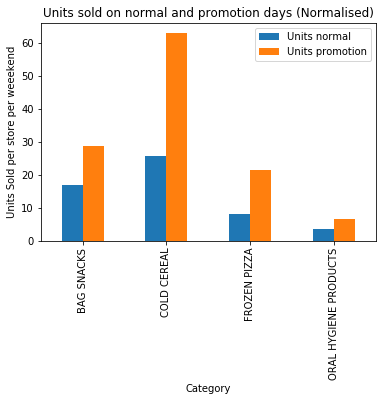

In [16]:
_ = Normalised_sales_combined.plot(kind='bar', x='CATEGORY', y=['UNITS_NORMAL', 'UNITS_DISC'],\
                        label=['Units normal', 'Units promotion'],\
                                   title='Units sold on normal and promotion days (Normalised)')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold per store per weeekend")
plt.show()

<font color = "green">
    Indeed, more units are sold on promotion days as compared to normal days.

#### Sales by Feature, Display, or TPR_Only (Normalised)

In [17]:
Ndays_feature = transactions[transactions.FEATURE==1]\
                     .groupby(['WEEK_END_DATE','UPC'])\
                     .STORE_NUM.size().reset_index()\
                     .groupby('UPC').STORE_NUM.sum().reset_index()\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').STORE_NUM.sum().reset_index()\
                     .rename(columns={'STORE_NUM':'NORM_UNITS_FEATURE'})
 
Ndays_display = transactions[transactions.DISPLAY==1]\
                     .groupby(['WEEK_END_DATE','UPC'])\
                     .STORE_NUM.size().reset_index()\
                     .groupby('UPC').STORE_NUM.sum().reset_index()\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').STORE_NUM.sum().reset_index()\
                     .rename(columns={'STORE_NUM':'NORM_UNITS_DISPLAY'})

Ndays_Only = transactions[transactions.TPR_ONLY==1]\
                     .groupby(['WEEK_END_DATE','UPC'])\
                     .STORE_NUM.size().reset_index()\
                     .groupby('UPC').STORE_NUM.sum().reset_index()\
                     .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                     .groupby('CATEGORY').STORE_NUM.sum().reset_index()\
                     .rename(columns={'STORE_NUM':'NORM_UNITS_ONLY'})

In [18]:
#Normalised most sucessful type of promotion: 

Normalised_sale_feature = Total_sale_feature.copy(deep= True)
Normalised_sale_feature.UNITS_FEATURE = Normalised_sale_feature.UNITS_FEATURE\
                                     /Ndays_feature.NORM_UNITS_FEATURE

Normalised_sale_display = Total_sale_display.copy(deep= True)
Normalised_sale_display.UNITS_DISPLAY = Normalised_sale_display.UNITS_DISPLAY\
                                      /Ndays_display.NORM_UNITS_DISPLAY

Normalised_sale_Only = Total_sale_Only.copy(deep= True)
Normalised_sale_Only.UNITS_ONLY = Normalised_sale_Only.UNITS_ONLY\
                                      /Ndays_Only.NORM_UNITS_ONLY

In [19]:
Normalised_disc_combined = Normalised_sale_feature\
                 .merge(Normalised_sale_display, on='CATEGORY', how='left')\
                 .merge(Normalised_sale_Only, on='CATEGORY', how='left')
Normalised_disc_combined

,CATEGORY,UNITS_FEATURE,UNITS_DISPLAY,UNITS_ONLY
0,BAG SNACKS,35.140462,44.315673,16.704998
1,COLD CEREAL,93.893280,92.303022,36.434502
2,FROZEN PIZZA,25.967638,27.746035,12.197750
3,ORAL HYGIENE PRODUCTS,10.210232,8.182900,5.366363


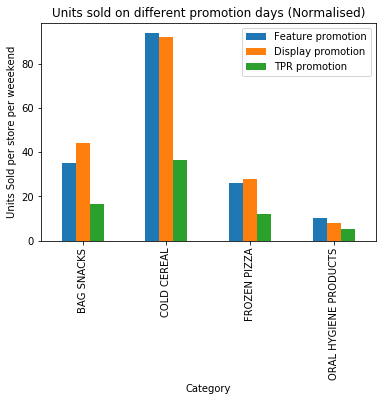

In [44]:
_ = Normalised_disc_combined.plot(kind='bar', x='CATEGORY', y=['UNITS_FEATURE', 'UNITS_DISPLAY', 'UNITS_ONLY'],\
                        label=['Feature promotion', 'Display promotion', 'TPR promotion'],\
                        title='Units sold on different promotion days (Normalised)')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold per store per weeekend")

plt.show()

<font color = "green">
    
   TPR discounts do not get the attention of many people, since they are not promoted or displayed actively in the store. Feature and discount are neck and neck in terms of the number of units sold.

#### How discount percentages impact sales

In [35]:
def discount_percentage_database(discount_class_length):
    discount = np.linspace(0,1,round(1/discount_class_length)+1)
    #discount = [ '%.2f' % elem for elem in discount ]
    discount_range = zip(discount[0:-1],discount[1:])
    normalised_bypercentage = pd.DataFrame({'CATEGORY': products.CATEGORY.unique()})
    for discount_bin in discount_range:
        d1=discount_bin[0]*100
        d2=discount_bin[1]*100
        temp='{}-{}%'.format('%.2f' % d1,'%.2f' % d2)
        sale_temp = transactions[(transactions.Discount_Percentage > discount_bin[0]) &\
                                  (transactions.Discount_Percentage <= discount_bin[1])]\
                      .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                      .groupby('CATEGORY').UNITS.sum().reset_index()\
                      .rename(columns={'UNITS':temp})
        ndays_temp = transactions[(transactions.Discount_Percentage > discount_bin[0]) &\
                                  (transactions.Discount_Percentage <= discount_bin[1])]\
                      .groupby(['WEEK_END_DATE','UPC'])\
                    .STORE_NUM.size().reset_index()\
                      .groupby('UPC').STORE_NUM.sum().reset_index()\
                      .merge(products[['UPC','CATEGORY']], on='UPC', how='left')\
                      .groupby('CATEGORY').STORE_NUM.sum().reset_index()
        sale_temp[temp] = sale_temp[temp]/ndays_temp.STORE_NUM
        normalised_bypercentage = normalised_bypercentage.merge(sale_temp, on='CATEGORY', how='left') 
    return normalised_bypercentage

In [42]:
discount_sales = discount_percentage_database(0.3)
discount_sales

,CATEGORY,0.00-33.33%,33.33-66.67%,66.67-100.00%
0,BAG SNACKS,25.368228,14.593081,4.963636
1,ORAL HYGIENE PRODUCTS,5.634873,9.574208,9.037037
2,COLD CEREAL,53.763967,118.007242,47.705882
3,FROZEN PIZZA,19.785781,32.041645,1.750000


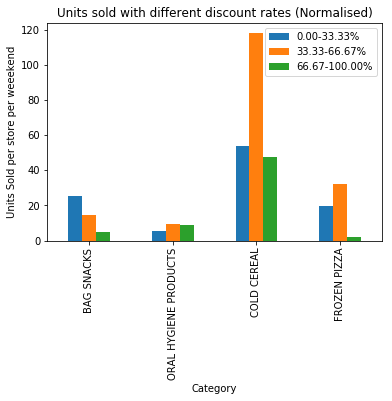

In [43]:
_ = discount_sales.plot(kind='bar', x='CATEGORY', y=discount_sales.columns.to_list()[1:],\
                        title='Units sold with different discount rates (Normalised)')
_ = plt.xlabel("Category")
_ = plt.ylabel("Units Sold per store per weeekend")
plt.show()

## How people use discount tickets

<font color = 'green'>

In this section we are going to analyze how discounts impact people’s shop habits, more precisely how people spend them. We shall look at these habits from 2 different perspective: the status of the person (owner or renter) and the composition of the person’s family. These two categories are defining for this part of the analysis since they offer a way to split our people into groups that might have different habits. Intuitively we expect to see that people those people who are renters and those who have families to spend use more discount tickets.

In [81]:
dataframes = datasets

In [82]:
demographic_df = dataframes['hh_demographic']

In [83]:
# Create dataframes for owners and renters
home_owner_df = demographic_df[demographic_df['HOMEOWNER_DESC'].apply(lambda e: e.lower()).str.contains('owner')]
renter_df = demographic_df[demographic_df['HOMEOWNER_DESC'].apply(lambda e: e.lower()).str.contains('renter')]

In [84]:
salary_ranges = list(demographic_df['INCOME_DESC'].unique())
age_ranges = list(demographic_df['AGE_DESC'].unique())

age_ranges.sort(key = lambda e: int(e.split('-')[0]) if len(e.split('-')[0]) == 2 else \
                        int(e.split('-')[0][: -1]))
salary_ranges.sort(key = lambda e: 0 if e.split('-')[0][0] == 'U' else \
                       int(e.split('-')[0][: -2] if len(e.split('-')) == 1 else \
                       int(e.split('-')[0])))

## How owners and renters spend their discount tickets

In [85]:
# Obtain the coupons redempt by both renters and owners
coupons_redempt_owners = pd.merge(dataframes['coupon_redempt'], home_owner_df, how = 'inner', on = ['household_key'])
coupons_redempt_renters = pd.merge(dataframes['coupon_redempt'], renter_df, how = 'inner', on = ['household_key'])

Age Range
19-24     8
25-34    11
35-44    15
45-54    15
55-64     2
65+       2
Name: Number of renters per age range, dtype: int64
Age Range
19-24    14
25-34    24
35-44    34
45-54    22
55-64     1
Name: Number coupons redeemed per number of renters of age range, dtype: int64


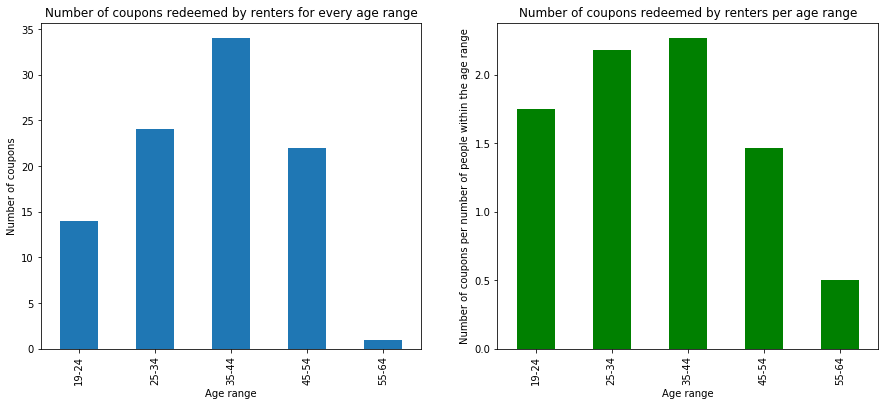

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

unnormalized = coupons_redempt_renters.groupby('AGE_DESC').size()
group_size = renter_df.groupby('AGE_DESC').size()

ax1 = unnormalized.plot.bar(ax = ax1)
ax1.set_title('Number of coupons redeemed by renters for every age range')
ax1.set_ylabel('Number of coupons')
ax1.set_xlabel('Age range')

ax2 = (1. * unnormalized / group_size)[: -1].plot.bar(ax = ax2, color = 'green')
ax2.set_title('Number of coupons redeemed by renters per age range')
ax2.set_ylabel('Number of coupons per number of people within the age range')
ax2.set_xlabel('Age range')

group_size.index.name = 'Age Range'
group_size.name = 'Number of renters per age range'

print(group_size)

unnormalized.index.name = 'Age Range'
unnormalized.name = 'Number coupons redeemed per number of renters of age range'

print(unnormalized)

<font color = "green">

* We see the proportions of coupons per age range are comparable even if the the numbers from people of differente ages are different.
* Also, looking at the at the 2 series from above the plots we see that none of the renters above 65 years old redeemed any coupon.

Age Range
19-24     13
25-34     75
35-44    130
45-54    194
55-64     44
65+       59
Name: Number of owners per age range, dtype: int64

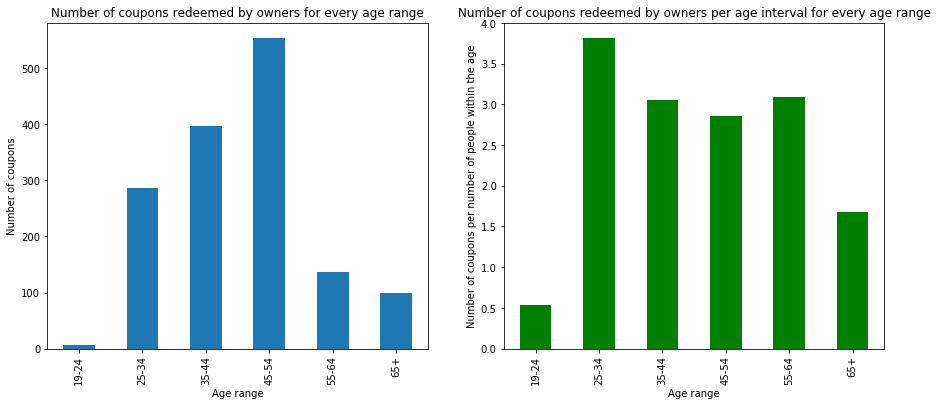

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

unnormalized = coupons_redempt_owners.groupby('AGE_DESC').size()
group_size = home_owner_df.groupby('AGE_DESC').size()

ax1 = unnormalized.plot.bar(ax = ax1)
ax1.set_title('Number of coupons redeemed by owners for every age range')
ax1.set_xlabel('Age range')
ax1.set_ylabel('Number of coupons')

ax2 = (unnormalized / group_size).plot.bar(ax = ax2, color = 'green')
ax2.set_title('Number of coupons redeemed by owners per age interval for every age range')
ax2.set_xlabel('Age range')
ax2.set_ylabel('Number of coupons per number of people within the age')

group_size.index.name = 'Age Range'
group_size.name = 'Number of owners per age range'
group_size

<font color = "green">

Looking at the normalised plots from above we see that owners use more discount coupons than renters when they pay for products. The only age category where renters use more is for people between 19-24 years old, which seems fair if you are young, you have a rent and want to save money. This makes us think that most of the owners with age between 25-64 years have families and might have a more regular buying habit that renters.

## What kind of people redeemed the coupons and on what kind of products

<font color = "green">

We saw in the previous plots that renters are much less than the owners and that owner redeem and that owners redeem much more discount tickets, which is not what we expected to see in the first instance. Since owners between 25-64 years redeem much more tickets that the others, in this section we shall look at what kind of families these people come from.

In [88]:
people = dataframes['hh_demographic']

# Obtain transaction where coupons were redeemed
coupons_redeemed = pd.merge(people, dataframes['coupon_redempt'], how = 'inner', on = 'household_key')
group_size_families = home_owner_df.groupby('HH_COMP_DESC').size()

HH_COMP_DESC
1 Adult Kids         25
2 Adults Kids       146
2 Adults No Kids    206
Single Female        63
Single Male          38
Unknown              37
dtype: int64

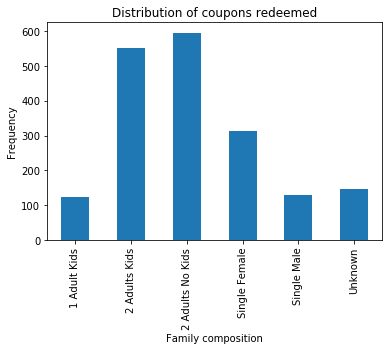

In [89]:
ax = coupons_redeemed.groupby('HH_COMP_DESC').size().plot.bar()
ax.set_xlabel('Family composition')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of coupons redeemed')

group_size_families

<font color = "green">

Above we can see some numbers that start to explain the intuition before, that most of the people have families regardless they have kids or not. We see that most of the redeemed tickets come from families, but because their number is dominant we shall have again a look at both the casual and the normalized plot. In order to have a better understanding about how people use their tickets, we can observe bellow the number of transactions for every category of products.

In [90]:
# Dataframe with all the transactions
transactions_df = pd.merge(people, dataframes['transaction_data'], how = 'inner', on = 'household_key')
transactions_products_df = pd.merge(transactions_df, dataframes['product'], how = 'inner', on = 'PRODUCT_ID')

Text(0.5, 1.0, 'Number of transactions for different types of products')

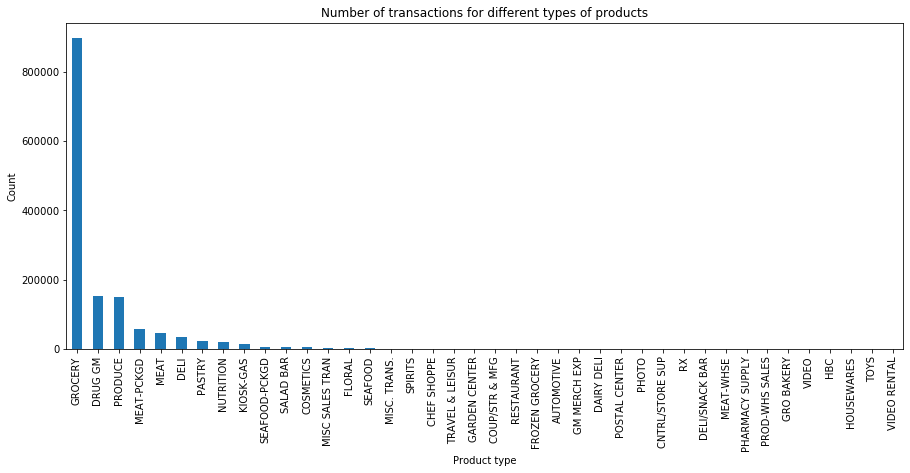

In [91]:
plt.subplots(figsize = [15, 6])
transactions_products_df.groupby('DEPARTMENT').size().sort_values(ascending = False).plot.bar()
plt.xlabel('Product type')
plt.ylabel('Count')
plt.title('Number of transactions for different types of products')

<font color = "green">
There are many categories of products, many of them quite similar, so we grouped the similar ones into higher categories. In the following analysis we chose five basic categories of products that every household has. In the left we have the higher categories grouping considered during the analysis and on the right we have the departments of products as they appear in the dataset:

* Groceries - GROCERY, PASTRY, GRO BAKERY, PASTRY, FROZEN GROCERY
* Meat - MEAT-PCKGD, MEAT, MEAT-WHSE, PORK
* Seafood - SEAFOOD-PCKGD, SEAFOOD
* Medicines - DRUG GM, PHARMACY SUPPLY
* Nutrition - NUTRITION

In [92]:
groceries = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                     isin(['GROCERY', 'PASTRY', 'GRO BAKERY', 'PASTRY', \
                                           'FROZEN GROCERY'])].groupby('HH_COMP_DESC').size()
meat = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['MEAT-PCKGD', 'MEAT', 'MEAT-WHSE', 'PORK'])].\
                                groupby('HH_COMP_DESC').size()
seafood = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['SEAFOOD-PCKGD', 'SEAFOOD'])].groupby('HH_COMP_DESC').size()
medicines = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['DRUG GM', 'PHARMACY SUPPLY'])].groupby('HH_COMP_DESC').size()
nutrition = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['NUTRITION'])].groupby('HH_COMP_DESC').size()

In [93]:
def plot_bar_series(series, xlabel, ylabel, title, ax, color = None):
    if color != None:
        ax = series.plot.bar(ax = ax, color = color)
    else:
        ax = series.plot.bar(ax = ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

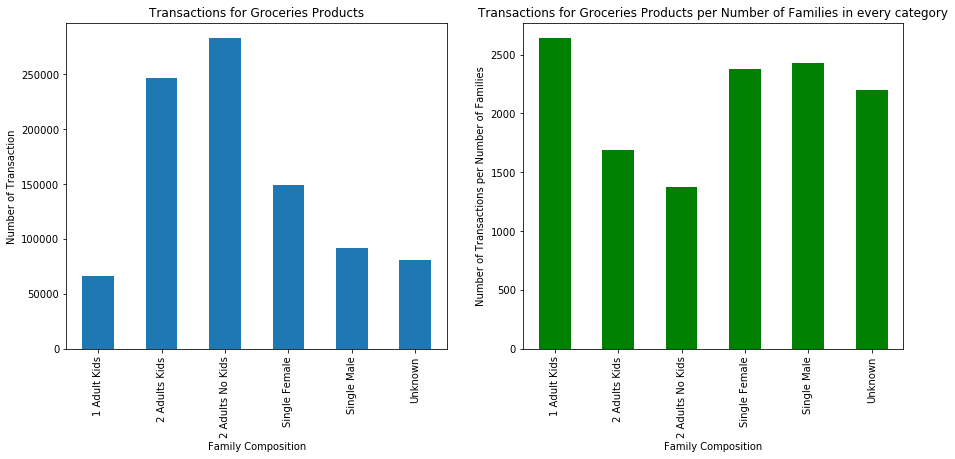

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(groceries, 'Family Composition', 'Number of Transaction', \
                'Transactions for Groceries Products', ax1)
plot_bar_series(groceries / group_size_families, 'Family Composition', 'Number of Transactions per Number of Families', \
                'Transactions for Groceries Products per Number of Families in every category', ax2, color = 'green')

<font color = "green">
    
The second plot provides a more honest comparison as we can notice that despite there are far less transactions for families with only 1 parent (because they are much less than families with 2 parents) we see that they buy groceries much more frequent  than families with 2 adults (with or without kids)

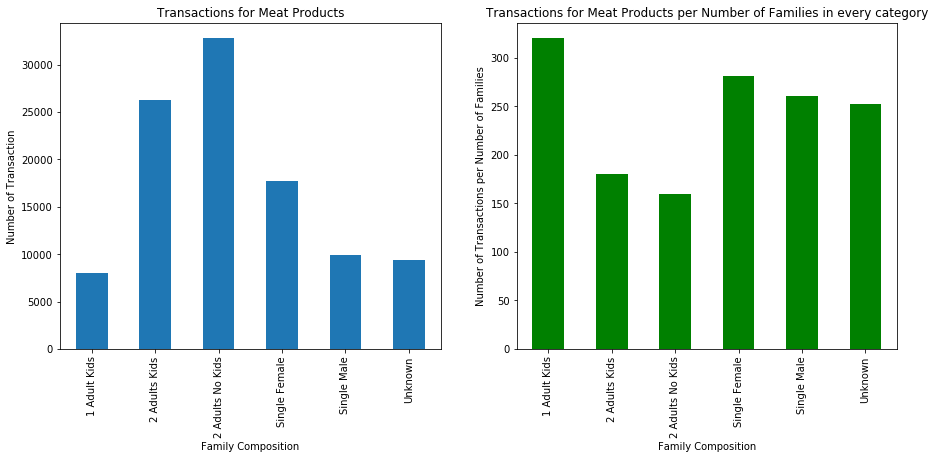

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(meat, 'Family Composition', 'Number of Transaction', 'Transactions for Meat Products', ax1)
plot_bar_series(meat / group_size_families, 'Family Composition', 'Number of Transactions per Number of Families', \
                'Transactions for Meat Products per Number of Families in every category', ax2, color = 'green')

<font color = "green">
    
* We see again the same behavior as in the plots for groceries, families with 1 adult buying more frequent than the others
* It is interesting to remark that signle females buy meat more frequently than men.

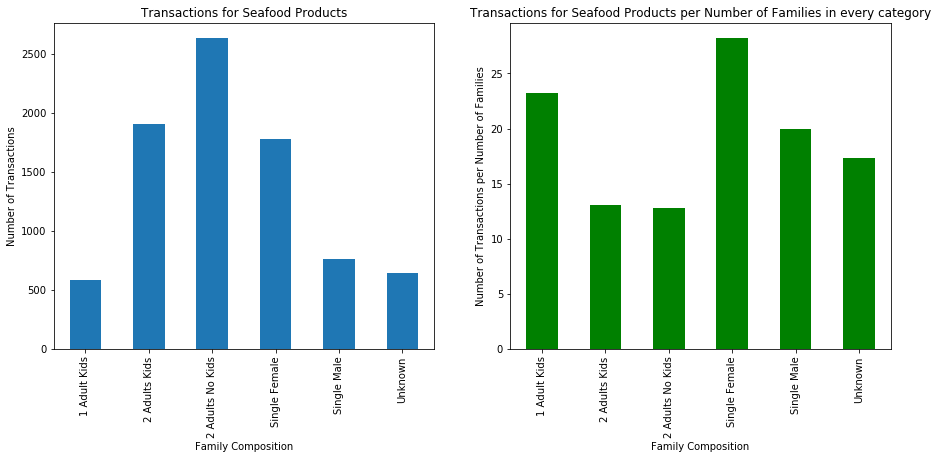

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(seafood, 'Family Composition', 'Number of Transactions', 'Transactions for Seafood Products', ax1)
plot_bar_series(seafood / group_size_families, 'Family Composition', 'Number of Transactions per Number of Families', \
                'Transactions for Seafood Products per Number of Families in every category', ax2, color = 'green')

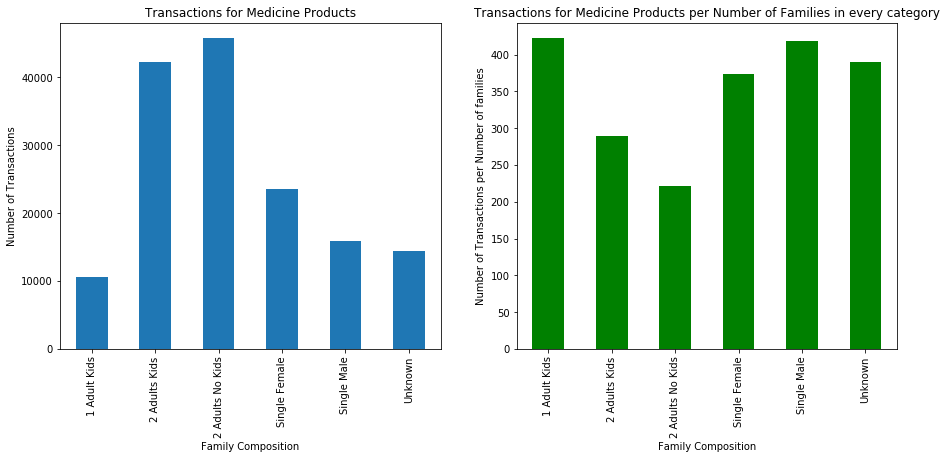

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(medicines, 'Family Composition', 'Number of Transactions', 'Transactions for Medicine Products', ax1)
plot_bar_series(medicines / group_size_families, 'Family Composition', 'Number of Transactions per Number of families', \
                'Transactions for Medicine Products per Number of Families in every category', ax2, color = 'green')

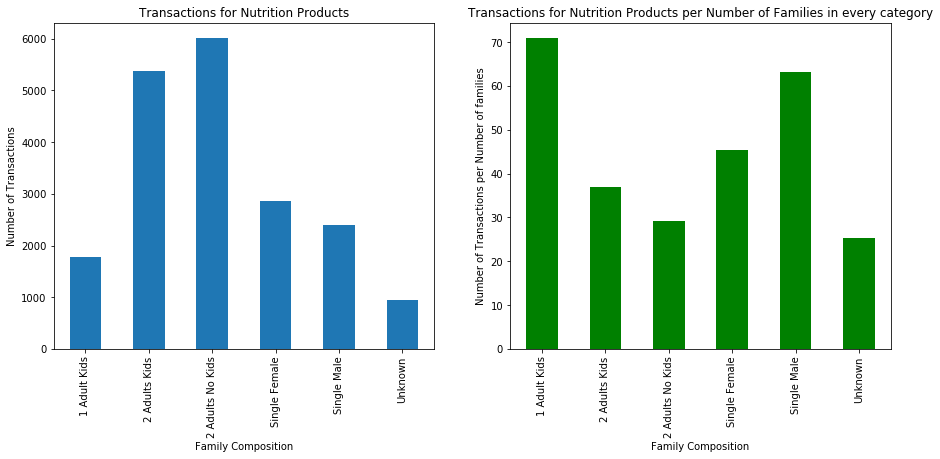

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(nutrition, 'Family Composition', 'Number of Transactions', 'Transactions for Nutrition Products', ax1)
plot_bar_series(nutrition / group_size_families, 'Family Composition', 'Number of Transactions per Number of families', \
                'Transactions for Nutrition Products per Number of Families in every category', ax2, color = 'green')

In [99]:
dataframes['product'][dataframes['product']['DEPARTMENT'] == 'NUTRITION']['SUB_COMMODITY_DESC'].unique()

array(['SOY BEVERAGE', 'TORTILLA CHIPS', 'DRINKS - CARB JUICE (OVER 50%',
       'RAISINS', 'POTATO CHIPS', 'FROZEN PIZZA', 'DRIED FRUIT - OTHER',
       'SPRING WATER', 'CEREAL - COLD', 'SOY/RICE MILK',
       'COOKIES/SWEET GOODS', 'FITNESS&DIET - BARS', 'SALSA/DIPS', 'MISC',
       'ASEPTIC MILK', 'TEA SWEETENED', 'SPECIALTY CHIPS (SOY CRISPS/PI',
       'JUICE (UNDER 10% JUICE)', 'RICE CAKES', 'YOGURT', 'PASTA/RAMEN',
       'FLUID MILK', 'MEATLESS/VEGETARIAN', 'LARGE - RICE CAKES',
       'DRIED FRUIT', 'FROZEN VEGETABLES',
       'BOXED PREPARED/ENTREE/DRY PREP', 'NON-CARB JCE (UNDER 50%JCE)',
       'DRESSINGS', 'SPECIALTY SNACKS (SOYNUTS/TRAI',
       'JUICE (OVER 50% JUICE)', 'CRACKERS', 'HONEY/SYRUP',
       'CANDY/CHOCOLATE', 'GRANOLA', 'NON-CARB JCE(OVER 50% JCE)',
       'VEGETABLES/DRY BEANS', 'BROTHS', 'FROZEN MEAT (VEGETARIAN)',
       'SPORTS NUTRITION', 'VEGETARIAN MISC', 'TOFU', 'FROZEN ENTREES',
       'FRZN MEAT ALTERNATIVES', 'NUT REFRIG JUICE OVER 50%',
       'B

<font color = "green">

* We see that single males byt more nutrtion products than signle women. If we look at the list of unique products from nutrition category we see that these products are not so healthy (like FROZEN BURGERS, CANDY W/O FLOUR etc).
* It seem that single females pay more attention with when they are going to shopping than single men.


* We can see that people use most of their discount tickets on groceries. Every person regardless the family type has the peak on the transactions that involve groceries.

* People that come from families with 1 parent and kids use considerably more discount tickets tickets than people from other types of families, which makes perfect sense if you are the only parent nd you have kids it would be in your interest to use discounts to buy products cheaper.

* People from families with two adults with/ without kids do not redeem so much tickets as expected. There might be two reasons for this behavior: they either have a more balanced behavior when it comes about shopping, they shop less, but when they do they redeem tickets or they do not seem interested in using tickets. If we look at the distribution of coupons redeemed we can draw the conclusion the high number of redeemed tickets comes indeed from the high number of people with families and that they do not seem as interested in using tickets as the others.

* Women take care of what they eat much more than men do. Women tend to use a comparable amount of discount on groceries, more on seafood and meat and much less on nutrition products that contain unhealthy products like chips, juice, sugar based products. These kind of products are avoided by women.

# Demographic groups' spendings

<font color = "green">

We shall look at shopping frequency, measured by how many days people went shopping within the study period. We break this down by all the available demographic groups to look for patterns.

In [100]:
dem_trans = pd.merge(datasets['hh_demographic'], datasets['transaction_data'], on='household_key')

Text(0.5, 1.0, 'Number of different days people of different ages went shopping in the study period')

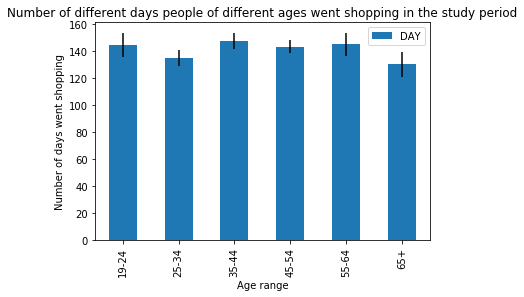

In [101]:
by_age = dem_trans.groupby(['household_key', 'AGE_DESC']).agg({'DAY': 'nunique'})
y = by_age.groupby('AGE_DESC')
y.mean().plot.bar(yerr=y.sem())
plt.xlabel('Age range')
plt.ylabel('Number of days went shopping')
plt.title('Number of different days people of different ages went shopping in the study period')

Text(0.5, 1.0, 'Number of different days people with different incomes went shopping in the study period')

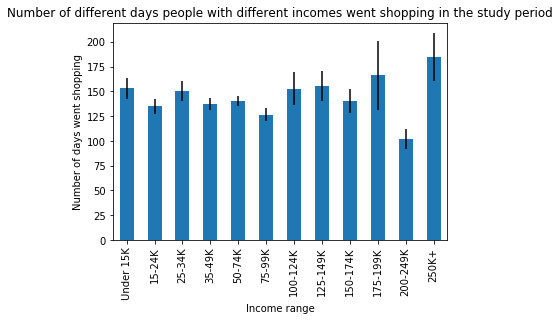

In [102]:
categories = ['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K',
              '125-149K', '150-174K', '175-199K', '200-249K', '250K+']

mapping = {income: i for i, income in enumerate(categories)}
by_income = dem_trans.groupby(['household_key', 'INCOME_DESC'], as_index=False).agg({'DAY': 'nunique'})
group = by_income.groupby('INCOME_DESC', as_index=False)
key = group.mean().INCOME_DESC.map(mapping)

group.mean().set_index('INCOME_DESC').iloc[key.argsort()].DAY.plot.bar(yerr=group.agg({'DAY': 'sem'}).set_index('INCOME_DESC').iloc[key.argsort()].DAY)
plt.xlabel('Income range')
plt.ylabel('Number of days went shopping')
plt.title('Number of different days people with different incomes went shopping in the study period')

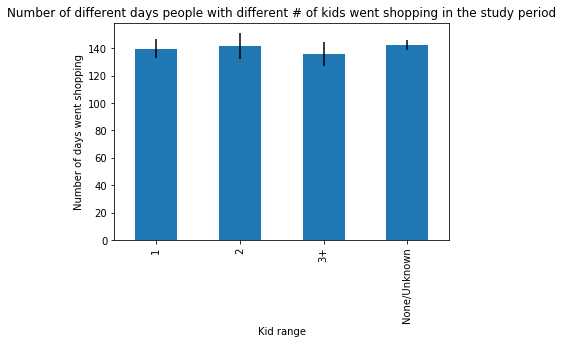

In [103]:
by_kids = dem_trans.groupby(['household_key', 'KID_CATEGORY_DESC']).agg({'DAY': 'nunique'})
y = by_kids.groupby('KID_CATEGORY_DESC')
y.mean().plot.bar(yerr=y.sem())
plt.xlabel('Kid range')
plt.ylabel('Number of days went shopping')
plt.title('Number of different days people with different # of kids went shopping in the study period')
plt.legend().remove()

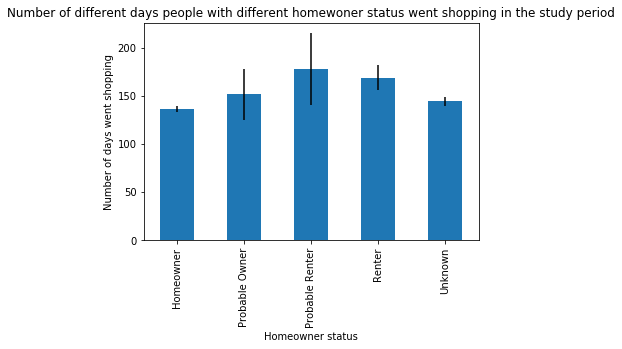

In [104]:
by_ho = dem_trans.groupby(['household_key', 'HOMEOWNER_DESC']).agg({'DAY': 'nunique'})
y = by_ho.groupby('HOMEOWNER_DESC')
y.mean().plot.bar(yerr=y.sem())
plt.xlabel('Homeowner status')
plt.ylabel('Number of days went shopping')
plt.title('Number of different days people with different homewoner status went shopping in the study period')
plt.legend().remove()

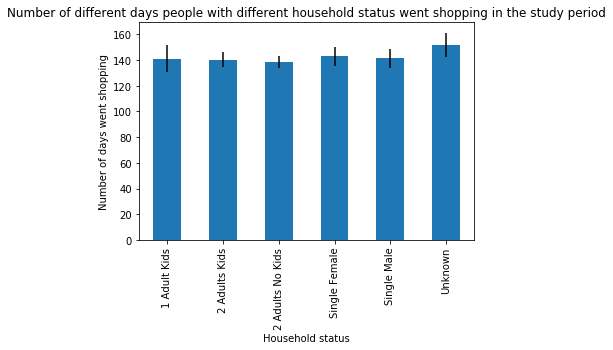

In [105]:
by_hh = dem_trans.groupby(['household_key', 'HH_COMP_DESC']).agg({'DAY': 'nunique'})
y = by_hh.groupby('HH_COMP_DESC')
y.mean().plot.bar(yerr=y.sem())
plt.xlabel('Household status')
plt.ylabel('Number of days went shopping')
plt.title('Number of different days people with different household status went shopping in the study period')
plt.legend().remove()

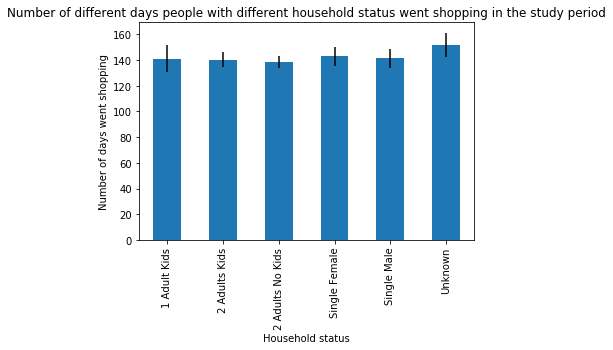

In [106]:
by_hh = dem_trans.groupby(['household_key', 'HH_COMP_DESC']).agg({'DAY': 'nunique'})
y = by_hh.groupby('HH_COMP_DESC')
y.mean().plot.bar(yerr=y.sem())
plt.xlabel('Household status')
plt.ylabel('Number of days went shopping')
plt.title('Number of different days people with different household status went shopping in the study period')
plt.legend().remove()

In [107]:
print('Number of households per category')
dem_trans.groupby(['INCOME_DESC']).agg({'household_key': 'nunique'})

Number of households per category


,household_key
INCOME_DESC,
100-124K,34
125-149K,38
15-24K,74
150-174K,30
175-199K,11
200-249K,5
25-34K,77
250K+,11
35-49K,172


In [108]:
print('Number of households with demographic info:', dem_trans.groupby(['INCOME_DESC']).agg({'household_key': 'nunique'}).sum()[0])

Number of households with demographic info: 801


<font color = "green">

The only demographic feature that shows a significant different in number of days they went shopping is the income category. The large dip for the 200-249k income category is quite suprising. However, checking the number of households per group, we see 200-249K has the least at only 5 households. We cannot assume that these 5 households reflect the trend in the rest of the population because this is a very small sample size. Thus, this dataset does not support the hypothesis that different demographic groups tend to shop with different frequencies. It would be helpful to have a larger dataset of demographic data, since this dataset had demographic information for only 801 households, with the distribution between groups being very uneven in some cases, as shown in the above table.

<font color = "green">

We have decided to not include the part in the final datastory since we did not have any particullar finiding.